# Overview

This notebook contains all experiment results exhibited in our paper.

In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set(style='white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from tqdm.auto import tqdm
from joblib import Parallel, delayed

def func(x, N=80):
    ret = x.ret.copy()
    x = x.rank(pct=True)
    x['ret'] = ret
    diff = x.score.sub(x.label)
    r = x.nlargest(N, columns='score').ret.mean()
    r -= x.nsmallest(N, columns='score').ret.mean()
    return pd.Series({
        'MSE': diff.pow(2).mean(), 
        'MAE': diff.abs().mean(), 
        'IC': x.score.corr(x.label),
        'R': r
    })
    
ret = pd.read_pickle("data/ret.pkl").clip(-0.1, 0.1)
def backtest(fname, **kwargs):
    pred = pd.read_pickle(fname).loc['2018-09-21':'2020-06-30']  # test period
    pred['ret'] = ret
    dates = pred.index.unique(level=0)
    res = Parallel(n_jobs=-1)(delayed(func)(pred.loc[d], **kwargs) for d in dates)
    res = {
       dates[i]: res[i]
       for i in range(len(dates))
    }
    res = pd.DataFrame(res).T
    r = res['R'].copy()
    r.index = pd.to_datetime(r.index)
    r = r.reindex(pd.date_range(r.index[0], r.index[-1])).fillna(0)  # paper use 365 days
    return {
        'MSE': res['MSE'].mean(),
        'MAE': res['MAE'].mean(),
        'IC': res['IC'].mean(),
        'ICIR': res['IC'].mean()/res['IC'].std(),
        'AR': r.mean()*365,
        'AV': r.std()*365**0.5,
        'SR': r.mean()/r.std()*365**0.5,
        'MDD': (r.cumsum().cummax() - r.cumsum()).max()
    }, r

def fmt(x, p=3, scale=1, std=False):
    _fmt = '{:.%df}'%p
    string = _fmt.format((x.mean() if not isinstance(x, (float, np.floating)) else x) * scale)
    if std and len(x) > 1:
        string += ' ('+_fmt.format(x.std()*scale)+')'
    return string

def backtest_multi(files, **kwargs):
    res = []
    pnl = []
    for fname in files:
        metric, r = backtest(fname, **kwargs)
        res.append(metric)
        pnl.append(r)
    res = pd.DataFrame(res)
    pnl = pd.concat(pnl, axis=1)
    return {
        'MSE': fmt(res['MSE'], std=True),
        'MAE': fmt(res['MAE'], std=True),
        'IC': fmt(res['IC']),
        'ICIR': fmt(res['ICIR']),
        'AR': fmt(res['AR'], scale=100, p=1)+'%',
        'VR': fmt(res['AV'], scale=100, p=1)+'%',
        'SR': fmt(res['SR']),
        'MDD': fmt(res['MDD'], scale=100, p=1)+'%'
    }, pnl

# Preparation


You could prepare the source data as below for the backtest code:
1. Linear: see Qlib examples
2. LightGBM: see Qlib examples
3. MLP: see Qlib examples
4. SFM: see Qlib examples
5. ALSTM: `qrun` configs/config_alstm.yaml
6. Transformer: `qrun` configs/config_transformer.yaml
7. ALSTM+TRA: `qrun` configs/config_alstm_tra_init.yaml && `qrun` configs/config_alstm_tra.yaml
8. Tranformer+TRA: `qrun` configs/config_transformer_tra_init.yaml && `qrun` configs/config_transformer_tra.yaml

In [2]:
exps = {
    'Linear': ['output/Linear/pred.pkl'],
    'LightGBM': ['output/GBDT/lr0.05_leaves128/pred.pkl'],
    'MLP': glob.glob('output/search/MLP/hs128_bs512_do0.3_lr0.001_seed*/pred.pkl'),
    'SFM': glob.glob('output/search/SFM/hs32_bs512_do0.5_lr0.001_seed*/pred.pkl'),
    'ALSTM': glob.glob('output/search/LSTM_Attn/hs256_bs1024_do0.1_lr0.0002_seed*/pred.pkl'),
    'Trans.': glob.glob('output/search/Transformer/head4_hs64_bs1024_do0.1_lr0.0002_seed*/pred.pkl'),
    'ALSTM+TS':glob.glob('output/LSTM_Attn_TS/hs256_bs1024_do0.1_lr0.0002_seed*/pred.pkl'),
    'Trans.+TS':glob.glob('output/Transformer_TS/head4_hs64_bs1024_do0.1_lr0.0002_seed*/pred.pkl'),
    'ALSTM+TRA(Ours)': glob.glob('output/search/finetune/LSTM_Attn_tra/K10_traHs16_traSrcLR_TPE_traLamb2.0_hs256_bs1024_do0.1_lr0.0001_seed*/pred.pkl'),
    'Trans.+TRA(Ours)': glob.glob('output/search/finetune/Transformer_tra/K3_traHs16_traSrcLR_TPE_traLamb1.0_head4_hs64_bs512_do0.1_lr0.0005_seed*/pred.pkl')
}

In [3]:
res = {
    name: backtest_multi(exps[name])
    for name in tqdm(exps)
}
report = pd.DataFrame({
    k: v[0]
    for k, v in res.items()
}).T

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
report
# print(report.to_latex())

,MSE,MAE,IC,ICIR,AR,VR,SR,MDD
Linear,0.163,0.327,0.020,0.132,-3.2%,16.8%,-0.191,32.1%
LightGBM,0.160,0.323,0.041,0.292,7.8%,15.5%,0.503,25.7%
MLP,0.160 (0.002),0.323 (0.003),0.037,0.273,3.7%,15.3%,0.264,26.2%
SFM,0.159 (0.001),0.321 (0.001),0.047,0.381,7.1%,14.3%,0.497,22.9%
ALSTM,0.158 (0.001),0.320 (0.001),0.053,0.419,12.3%,13.7%,0.897,20.2%
Trans.,0.158 (0.001),0.322 (0.001),0.051,0.400,14.5%,14.2%,1.028,22.5%
ALSTM+TS,0.160 (0.002),0.321 (0.002),0.039,0.291,6.7%,14.6%,0.480,22.3%
Trans.+TS,0.160 (0.004),0.324 (0.005),0.037,0.278,10.4%,14.7%,0.722,23.7%
ALSTM+TRA(Ours),0.157 (0.000),0.318 (0.000),0.059,0.460,12.4%,14.0%,0.885,20.4%
Trans.+TRA(Ours),0.157 (0.000),0.320 (0.000),0.056,0.442,16.1%,14.2%,1.133,23.1%


# RQ1

Case study

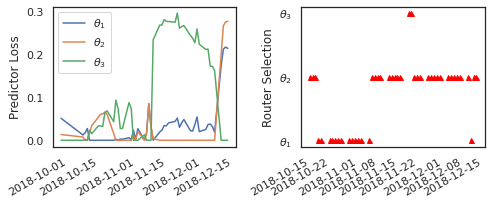

In [5]:
df = pd.read_pickle('output/search/finetune/Transformer_tra/K3_traHs16_traSrcLR_TPE_traLamb0.0_head4_hs64_bs512_do0.1_lr0.0005_seed1000/pred.pkl')
code = 'SH600157'
date = '2018-09-28'
lookbackperiod = 50

prob = df.iloc[:, -3:].loc(axis=0)[:, code].reset_index(level=1, drop=True).loc[date:].iloc[:lookbackperiod]
pred = df.loc[:,["score_0","score_1","score_2","label"]].loc(axis=0)[:, code].reset_index(level=1, drop=True).loc[date:].iloc[:lookbackperiod]
e_all = pred.iloc[:,:-1].sub(pred.iloc[:,-1], axis=0).pow(2)
e_all = e_all.sub(e_all.min(axis=1), axis=0)
e_all.columns = [r'$\theta_%d$'%d for d in range(1, 4)]
prob = pd.Series(np.argmax(prob.values, axis=1), index=prob.index).rolling(7).mean().round()

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
e_all.plot(ax=axes[0], xlabel='', rot=30)
prob.plot(ax=axes[1], xlabel='', rot=30, color='red', linestyle='None', marker='^', markersize=5)
plt.yticks(np.array([0, 1, 2]), e_all.columns.values)
axes[0].set_ylabel('Predictor Loss')
axes[1].set_ylabel('Router Selection')
plt.tight_layout()
# plt.savefig('select.pdf', bbox_inches='tight')
plt.show()

# RQ2

You could prepared the source data for this test as below:
1. Random: Setting `src_info` = "NONE"
2. LR: Setting `src_info` = "LR"
3. TPE: Setting `src_info` = "TPE"
4. LR+TPE: Setting `src_info` = "LR_TPE"

In [6]:
exps = {
    'Random': glob.glob('output/search/LSTM_Attn_tra/K10_traHs16_traSrcNONE_traLamb1.0_hs256_bs1024_do0.1_lr0.0001_seed*/pred.pkl'),
    'LR': glob.glob('output/search/LSTM_Attn_tra/K10_traHs16_traSrcLR_traLamb1.0_hs256_bs1024_do0.1_lr0.0001_seed*/pred.pkl'),
    'TPE': glob.glob('output/search/LSTM_Attn_tra/K10_traHs16_traSrcTPE_traLamb1.0_hs256_bs1024_do0.1_lr0.0001_seed*/pred.pkl'),
    'LR+TPE': glob.glob('output/search/finetune/LSTM_Attn_tra/K10_traHs16_traSrcLR_TPE_traLamb2.0_hs256_bs1024_do0.1_lr0.0001_seed*/pred.pkl')
}

In [7]:
res = {
    name: backtest_multi(exps[name])
    for name in tqdm(exps)
}
report = pd.DataFrame({
    k: v[0]
    for k, v in res.items()
}).T

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
report
# print(report.to_latex())

,MSE,MAE,IC,ICIR,AR,VR,SR,MDD
Random,0.159 (0.001),0.321 (0.002),0.048,0.362,11.4%,14.1%,0.810,21.1%
LR,0.158 (0.001),0.320 (0.001),0.053,0.409,10.3%,13.4%,0.772,20.8%
TPE,0.158 (0.001),0.321 (0.001),0.049,0.381,10.3%,14.0%,0.741,21.2%
LR+TPE,0.157 (0.000),0.318 (0.000),0.059,0.460,12.4%,14.0%,0.885,20.4%


# RQ3

Set `lamb` = 0 to obtain results without Optimal Transport(OT)

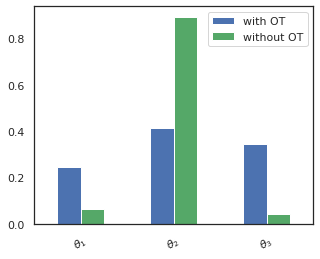

In [9]:
a = pd.read_pickle('output/search/finetune/Transformer_tra/K3_traHs16_traSrcLR_TPE_traLamb0.0_head4_hs64_bs512_do0.1_lr0.0005_seed3000/pred.pkl')
b = pd.read_pickle('output/search/finetune/Transformer_tra/K3_traHs16_traSrcLR_TPE_traLamb2.0_head4_hs64_bs512_do0.1_lr0.0005_seed3000/pred.pkl')
a = a.iloc[:, -3:]
b = b.iloc[:, -3:]
b = np.eye(3)[b.values.argmax(axis=1)]
a = np.eye(3)[a.values.argmax(axis=1)]

res = pd.DataFrame({
    'with OT': b.sum(axis=0) / b.sum(),
    'without OT': a.sum(axis=0)/ a.sum()  
},index=[r'$\theta_1$',r'$\theta_2$',r'$\theta_3$'])
res.plot.bar(rot=30, figsize=(5, 4), color=['b', 'g'])
del a, b

# RQ4

You could prepared the source data for this test as below:
1. K=1: which is exactly the alstm model
2. K=3: Setting `num_states` = 3
3. K=5: Setting `num_states` = 5
4. K=10: Setting `num_states` = 10
5. K=20: Setting `num_states` = 20


In [10]:
exps = {
    'K=1': glob.glob('output/search/LSTM_Attn/hs256_bs1024_do0.1_lr0.0002_seed*/info.json'),
    'K=3': glob.glob('output/search/finetune/LSTM_Attn_tra/K3_traHs16_traSrcLR_TPE_traLamb2.0_hs256_bs1024_do0.1_lr0.0001_seed*/info.json'),
    'K=5': glob.glob('output/search/finetune/LSTM_Attn_tra/K5_traHs16_traSrcLR_TPE_traLamb2.0_hs256_bs1024_do0.1_lr0.0001_seed*/info.json'),
    'K=10': glob.glob('output/search/finetune/LSTM_Attn_tra/K10_traHs16_traSrcLR_TPE_traLamb2.0_hs256_bs1024_do0.1_lr0.0001_seed*/info.json'),
    'K=20': glob.glob('output/search/finetune/LSTM_Attn_tra/K20_traHs16_traSrcLR_TPE_traLamb2.0_hs256_bs1024_do0.1_lr0.0001_seed*/info.json')
}

In [11]:
report = dict()
for k, v in exps.items():
    
    tmp = dict()
    for fname in v:
        with open(fname) as f:
            info = json.load(f)
        tmp[fname] = (
        {
            "IC":info["metric"]["IC"],
            "MSE":info["metric"]["MSE"]
        })
    tmp = pd.DataFrame(tmp).T
    report[k] = tmp.mean()
report = pd.DataFrame(report).T

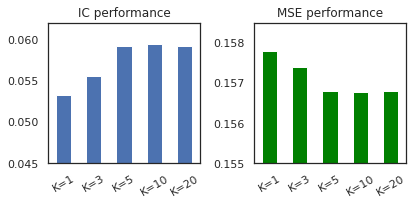

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(6,3)); axes = axes.flatten()
report['IC'].plot.bar(rot=30, ax=axes[0])
axes[0].set_ylim(0.045, 0.062)
axes[0].set_title('IC performance')
report['MSE'].astype(float).plot.bar(rot=30, ax=axes[1], color='green')
axes[1].set_ylim(0.155, 0.1585)
axes[1].set_title('MSE performance')
plt.tight_layout()
# plt.savefig('sensitivity.pdf')

In [13]:
report

,IC,MSE
K=1,0.053247,0.157792
K=3,0.055535,0.157410
K=5,0.059224,0.156796
K=10,0.059403,0.156766
K=20,0.059193,0.156801
